### Result Analysis QM7X and MD17

Models:
*   SchNet
*   Field SchNet
*   PaiNN
*   SO(3)Net





In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import os
from scipy.interpolate import make_interp_spline
import numpy as np
from scipy.ndimage import median_filter

In [6]:
# df1 = pd.read_csv('/content/drive/MyDrive/000/plot_data/train_e_mae/version_0.csv')

In [2]:
def load_data(directory):
    data = {}
    for version in ['version_0', 'version_1', 'version_2']:
        file_path = os.path.join(directory, f"{version}.csv")
        if os.path.exists(file_path):
            data[version] = pd.read_csv(file_path)
        else:
            print(f"File {file_path} not found.")
    return data

In [3]:
def smooth_curve(x, y, points=300, k=3):
    x_new = np.linspace(x.min(), x.max(), points)
    spline = make_interp_spline(x, y, k=k)
    y_smooth = spline(x_new)
    return x_new, y_smooth

def exponential_moving_average(data, span):
    return data.ewm(span=span, adjust=False).mean()

In [4]:
version_labels = {
    'version_0': 'SchNet',
    'version_1': 'FieldSchNet',
    'version_2': 'PaiNN',
    'version_3': 'SO(3)Net'
}

In [5]:
# /content/drive/MyDrive/000/data-analysis/energy/train/MD17/version_1.csv

In [6]:
def load_results():
  base_dir = '/content/drive/MyDrive/000/data-analysis'
  res = {}
  for dataset in ['QM7X', 'MD17']:
    res[dataset] = {}
    for categoty in ['energy', 'force']:
      res[dataset][categoty] = {}
      for mode in ['train', 'val']:
        res[dataset][categoty][mode] = {}
        for version in ['version_0', 'version_1', 'version_2', 'version_3']:
          file_path = os.path.join(base_dir, categoty, mode, dataset, f"{version}.csv")
          if os.path.exists(file_path):
            res[dataset][categoty][mode][version_labels[version]] = pd.read_csv(file_path)
          else:
            print(f"File {file_path} not found.")

  return res

In [7]:
results = load_results()

In [8]:
# results

In [9]:
# base_dir = '/content/drive/MyDrive/000/plot_data'
# train_e_mae = load_data(os.path.join(base_dir, 'train_e_mae'))
# train_f_mae = load_data(os.path.join(base_dir, 'train_f_mae'))
# val_e_mae = load_data(os.path.join(base_dir, 'val_e_mae'))
# val_f_mae = load_data(os.path.join(base_dir, 'val_f_mae'))

### QM17X Dataset

In [10]:
def get_result(model, data, mode, top_k = 10):
  e_candidates = data['energy'][mode][model].nsmallest(top_k, 'Value')
  f_candidates = data['force'][mode][model].nsmallest(top_k, 'Value')

  e_mean = e_candidates['Value'].mean()
  e_std = e_candidates['Value'].std(ddof=1)

  f_mean = f_candidates['Value'].mean()
  f_std = f_candidates['Value'].std(ddof=1)

  return e_mean, e_std, f_mean, f_std


In [11]:
qm7x_result = results['QM7X']

for model in ['SchNet', 'FieldSchNet', 'PaiNN', 'SO(3)Net']:
  e_mean, e_std, f_mean, f_std = get_result(model, qm7x_result, 'val', top_k=15)
  print(f"Result for {model}:")
  print(f"Energy = {e_mean:.2f} +/- {e_std:.2f}  | Force = {f_mean:.2f} +/- {f_std:.2f}")
  print("----------------------------------------------------------------")


Result for SchNet:
Energy = 3.66 +/- 0.38  | Force = 1.81 +/- 0.03
----------------------------------------------------------------
Result for FieldSchNet:
Energy = 1.94 +/- 0.09  | Force = 1.15 +/- 0.01
----------------------------------------------------------------
Result for PaiNN:
Energy = 0.49 +/- 0.05  | Force = 0.36 +/- 0.00
----------------------------------------------------------------
Result for SO(3)Net:
Energy = 1.86 +/- 0.13  | Force = 0.80 +/- 0.01
----------------------------------------------------------------


### MD17 Dataset

In [12]:
md17_result = results['MD17']

for model in ['SchNet', 'FieldSchNet', 'PaiNN', 'SO(3)Net']:
  e_mean, e_std, f_mean, f_std = get_result(model, md17_result, 'val', top_k=15)
  print(f"Result for {model}:")
  print(f"Energy = {e_mean:.2f} +/- {e_std:.2f}  | Force = {f_mean:.2f} +/- {f_std:.2f}")
  print("----------------------------------------------------------------")


Result for SchNet:
Energy = 0.20 +/- 0.03  | Force = 0.51 +/- 0.01
----------------------------------------------------------------
Result for FieldSchNet:
Energy = 0.20 +/- 0.02  | Force = 0.49 +/- 0.01
----------------------------------------------------------------
Result for PaiNN:
Energy = 0.09 +/- 0.02  | Force = 0.19 +/- 0.01
----------------------------------------------------------------
Result for SO(3)Net:
Energy = 0.14 +/- 0.02  | Force = 0.43 +/- 0.01
----------------------------------------------------------------


In [189]:
def draw_figure(data1, data2, plot_title, plot1_title, plot2_title, fig_path,
                p1_lim=(None,None), p2_lim=(None,None), smooth1=10, smooth2=10, p1_vertical_line=(0,0,""), p2_vertical_line=(0,0,"")):
  fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(18, 6), sharex=True)

  # Plot1
  for version, data in data1.items():
    x_smooth = data['Step']
    y_smooth = data['Value'] if smooth1 == 0 else exponential_moving_average(data['Value'], span=smooth1)
    ax1.plot(x_smooth, y_smooth, label=f'{version}')

  ax1.set_title(plot1_title)
  ax1.set_xlabel('Step')
  ax1.set_ylabel('MAE')

  vertical_line_pos, text_pos, vertical_line_text = p1_vertical_line
  if vertical_line_pos > 0:
    x_vline = vertical_line_pos
    ax1.axvline(x=x_vline, color='gray', linestyle='--', label=f'SO(3)Net Training Continues')

  ax1.legend()


  x_lim, y_lim = p1_lim
  if x_lim is not None:
    ax1.set_xlim(left=0, right=x_lim)
  if y_lim is not None:
    ax1.set_ylim(bottom=0, top=y_lim)

  # Plot2
  for version, data in data2.items():
    x_smooth = data['Step']
    y_smooth = data['Value'] if smooth2 == 0 else exponential_moving_average(data['Value'], span=smooth2)
    ax2.plot(x_smooth, y_smooth, label=f'{version}')

  vertical_line_pos, text_pos, vertical_line_text = p2_vertical_line
  if vertical_line_pos > 0:
    x_vline = vertical_line_pos
    ax2.axvline(x=x_vline, color='gray', linestyle='--', label=f'SO(3)Net Training Continues')


  x_lim, y_lim = p2_lim
  if x_lim is not None:
    ax2.set_xlim(left=0, right=x_lim)
  if y_lim is not None:
    ax2.set_ylim(bottom=0, top=y_lim)

  ax2.set_title(plot2_title)
  ax2.set_xlabel('Step')
  ax2.set_ylabel('MAE')
  ax2.legend()

  # Main title
  fig.suptitle(plot_title, fontsize=16)

  plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout to accommodate the main title
  plt.savefig(fig_path)
  plt.show()

In [126]:
train_energy_md17 = {
  key: md17_result['energy']['train'][key] for key in md17_result['energy']['train'].keys()
}

train_force_md17 = {
  key: md17_result['force']['train'][key] for key in md17_result['force']['train'].keys()
}

val_energy_md17 = {
  key: md17_result['energy']['val'][key] for key in md17_result['energy']['val'].keys()
}

val_force_md17 = {
  key: md17_result['force']['val'][key] for key in md17_result['force']['val'].keys()
}

train_energy_qm7x = {
  key: qm7x_result['energy']['train'][key] for key in qm7x_result['energy']['train'].keys()
}

train_force_qm7x = {
  key: qm7x_result['force']['train'][key] for key in qm7x_result['force']['train'].keys()
}

val_energy_qm7x = {
  key: qm7x_result['energy']['val'][key] for key in qm7x_result['energy']['val'].keys()
}

val_force_qm7x = {
  key: qm7x_result['force']['val'][key] for key in qm7x_result['force']['val'].keys()
}

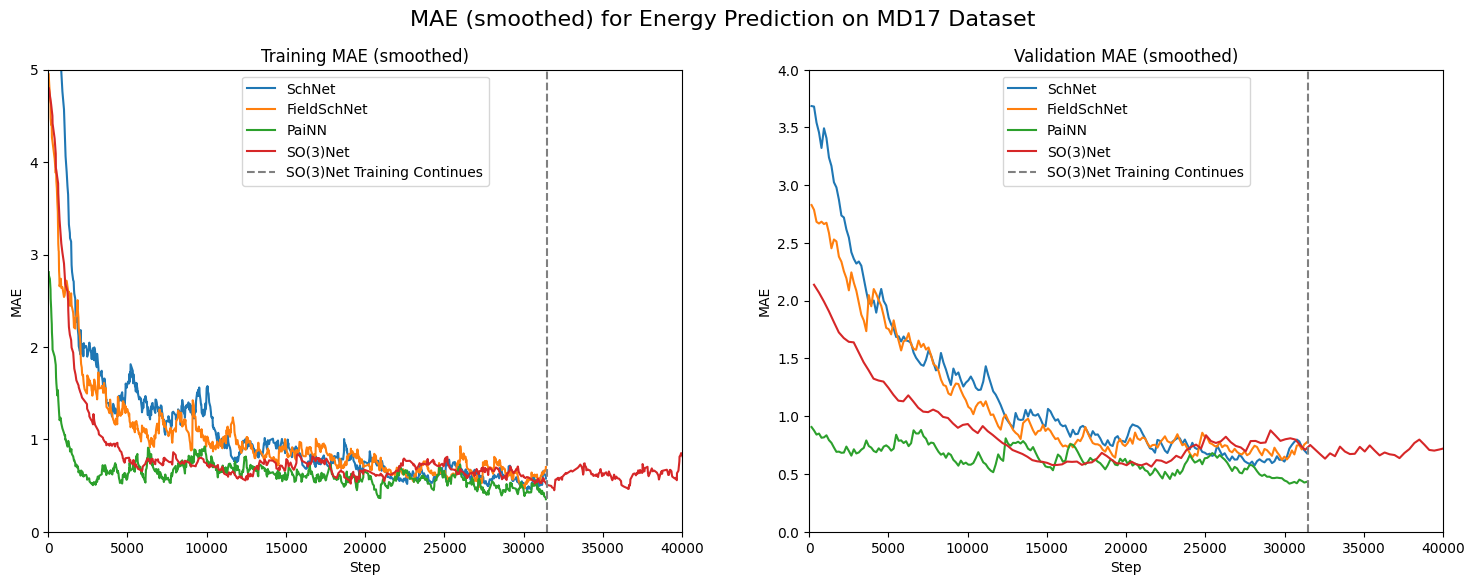

In [159]:
draw_figure(train_energy_md17, val_energy_md17,
            plot_title="MAE (smoothed) for Energy Prediction on MD17 Dataset",
            plot1_title="Training MAE (smoothed)",
            plot2_title="Validation MAE (smoothed)",
            fig_path="/content/drive/MyDrive/000/plot_data/md17_energy_mae_plot.png",
            p1_lim=(40000, 5), p2_lim=(40000, 4),
            smooth1=32, smooth2=25,
            p1_vertical_line=(31500,3,"SO(3)Net Training Continues"),
            p2_vertical_line=(31500,2,"SO(3)Net Training Continues")
)


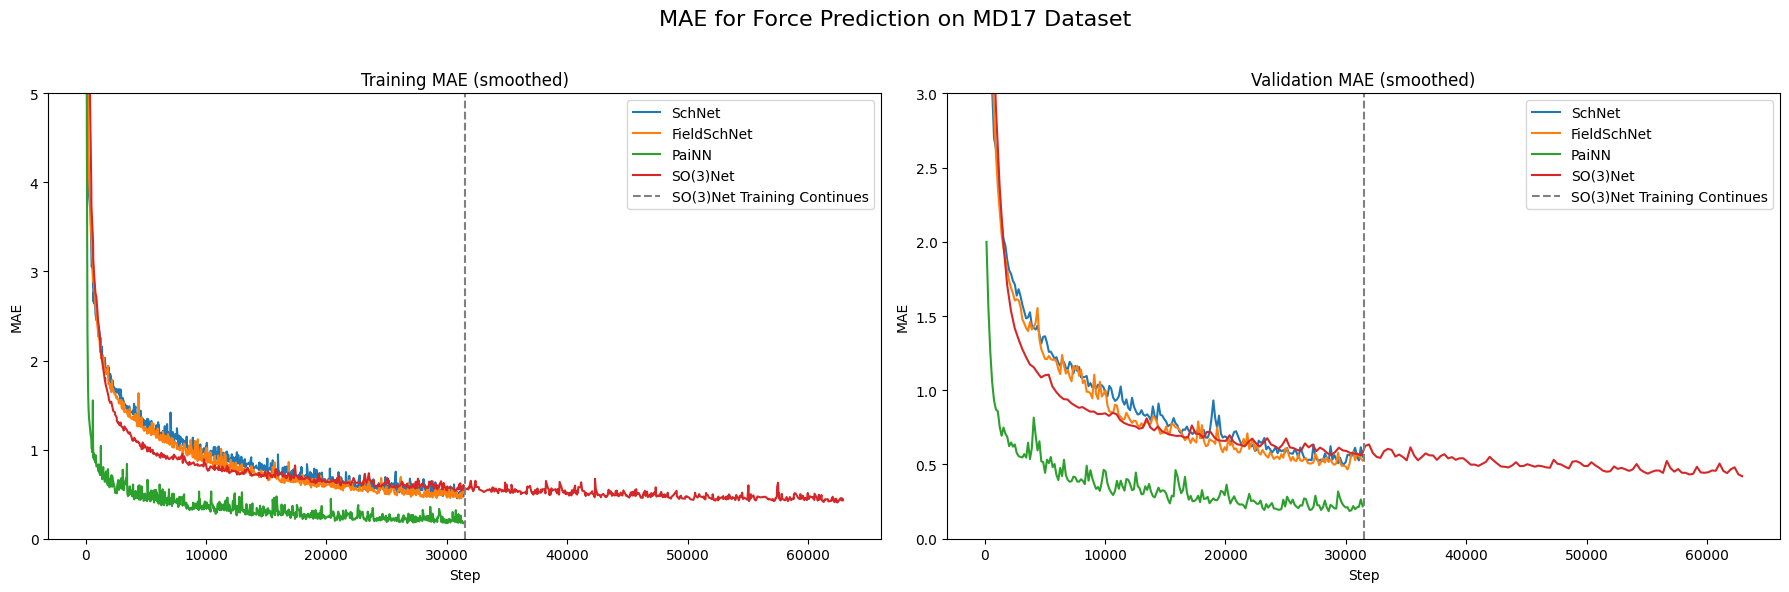

In [194]:
draw_figure(train_force_md17, val_force_md17,
            plot_title="MAE for Force Prediction on MD17 Dataset",
            plot1_title="Training MAE (smoothed)",
            plot2_title="Validation MAE (smoothed)",
            fig_path="/content/drive/MyDrive/000/data-analysis/plots/md17_force_mae_plot.png",
            p1_lim=(None, 5), p2_lim=(None, 3),
            smooth1=2, smooth2=2,
            p1_vertical_line=(31500,3,"SO(3)Net Training Continues"),
            p2_vertical_line=(31500,2,"SO(3)Net Training Continues")
)

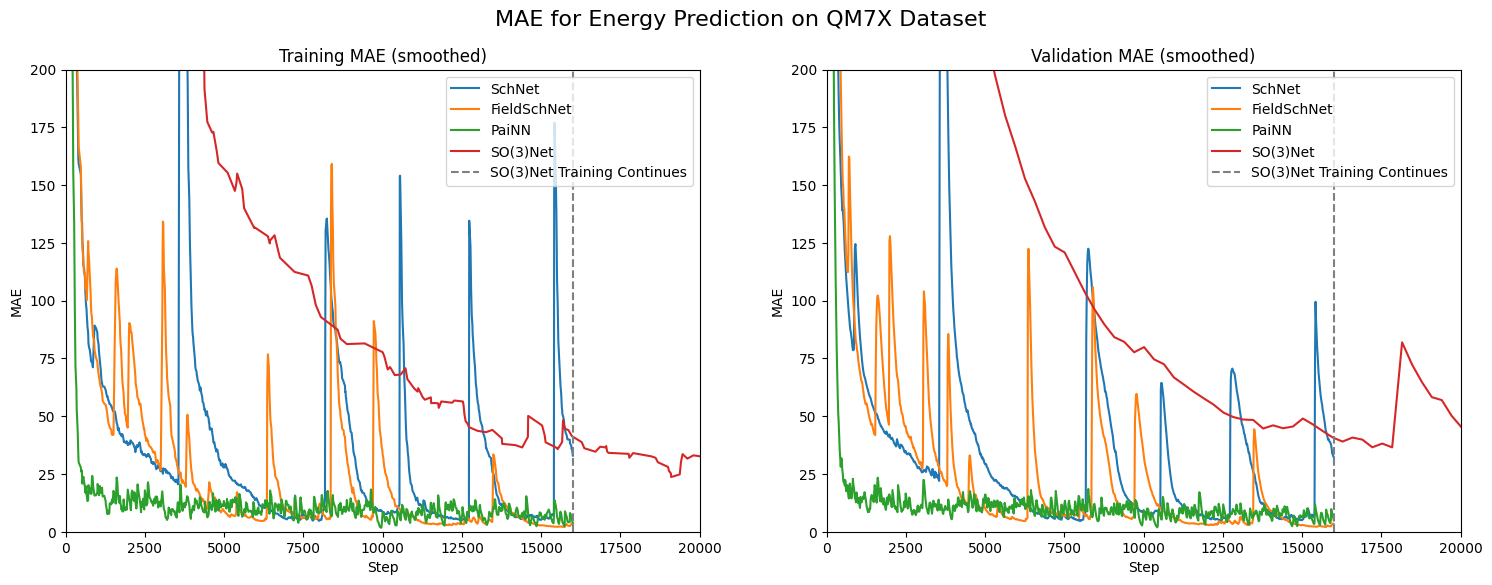

In [162]:
draw_figure(train_energy_qm7x, val_energy_qm7x,
            plot_title="MAE for Energy Prediction on QM7X Dataset",
            plot1_title="Training MAE (smoothed)",
            plot2_title="Validation MAE (smoothed)",
            fig_path="/content/drive/MyDrive/000/plot_data/md17_energy_mae_plot.png",
            p1_lim=(20000, 200), p2_lim=(None, 200),
            smooth1=10, smooth2=10,
            p1_vertical_line=(16000,3,"SO(3)Net Training Continues"),
            p2_vertical_line=(16000,2,"SO(3)Net Training Continues")
)


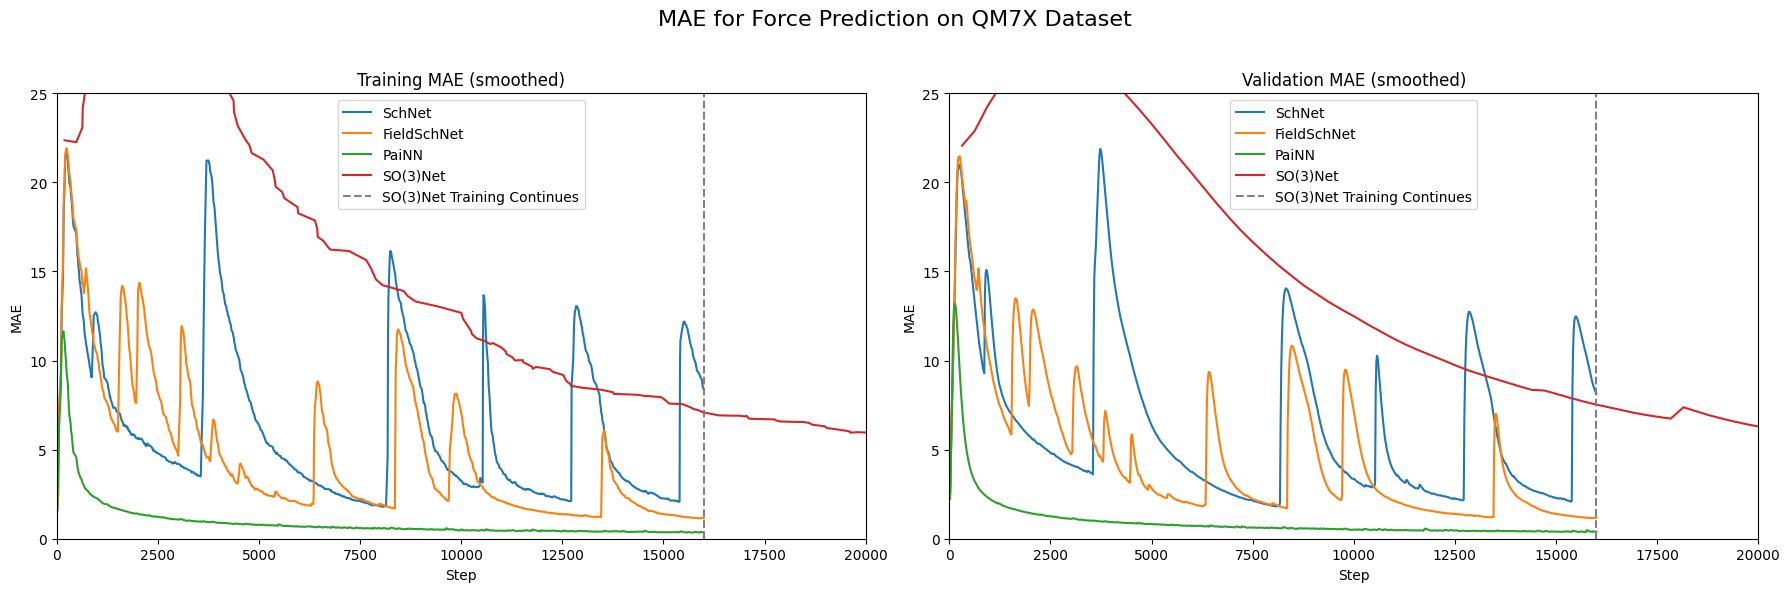

In [193]:
draw_figure(train_force_qm7x, val_force_qm7x,
            plot_title="MAE for Force Prediction on QM7X Dataset",
            plot1_title="Training MAE (smoothed)",
            plot2_title="Validation MAE (smoothed)",
            fig_path="/content/drive/MyDrive/000/data-analysis/plots/qm7x_force_mae_plot.png",
            p1_lim=(20000, 25), p2_lim=(None, 25),
            smooth1=10, smooth2=10,
            p1_vertical_line=(16000,3,"SO(3)Net Training Continues"),
            p2_vertical_line=(16000,2,"SO(3)Net Training Continues")
)